In [138]:
import pandas as pd
import numpy as np
import sklearn as sk

In [139]:
df1 = pd.read_csv("politifact_with_bio_data.csv")

In [140]:
df1.head()

,Unnamed: 0.1,index,Unnamed: 0,name,claim date,claim source,claim,issue,accuracy rating,id.bioguide,id.wikipedia,bio.gender,bio.birthday,type,party,start,end,state,full name,accuracy
0,0,2,2,Mark Kelly,"August 5, 2022",an ad,Blake Masters “wants to pass a national ban on...,abortion,mostly-true,K000377,Mark Kelly,M,21/2/1964,sen,Democrat,2/12/2020,3/1/2023,AZ,Mark Kelly,1
1,1,9,9,Mariannette Miller-Meeks,"July 17, 2022",a newsletter,The Democrats’ Women’s Health Protection Act o...,abortion,barely-true,M001215,Mariannette Miller-Meeks,F,6/9/1955,rep,Republican,3/1/2021,3/1/2023,IA,Mariannette Miller-Meeks,0
2,2,25,25,Catherine Cortez Masto,"June 14, 2022",an ad,"Adam Laxalt ""supports eliminating Nevada's pro...",abortion,half-true,C001113,Catherine Cortez Masto,F,29/3/1964,sen,Democrat,3/1/2017,3/1/2023,NV,Catherine Cortez Masto,0
3,3,28,28,Tammy Baldwin,"May 4, 2022",TV interview,"""Our Supreme Court has never taken away a cons...",abortion,FALSE,B001230,Tammy Baldwin,F,11/2/1962,rep,Democrat,6/1/1999,3/1/2001,WI,Tammy Baldwin,0
4,4,29,29,Ron Johnson,"May 11, 2022",News release,In the immediate wake of a fire and vandalism ...,abortion,barely-true,J000293,Ron Johnson (Wisconsin politician),M,8/4/1955,sen,Republican,5/1/2011,3/1/2017,WI,Ron Johnson,0


##### Drop rows of the same claim but categorised under different issues to avoid data leakage when splitting

In [141]:
print("there are: {rows}".format(rows=df1.shape))
print("but only {n} unique claims".format(n=df1['claim'].unique().__len__()))

there are: (6396, 20)
but only 4027 unique claims


Upon inspection this is the result of politcas grouping the same article under different issues. The duplicates need to be removed to avoid data leakage.

In [142]:
df2 = df1.drop_duplicates(subset=['claim'], keep='first')

In [143]:
claims = df2['claim']
issues = []
for c in claims:
    issues.append(' '.join(df1[df1['claim']==c]['issue'].unique()))

In [144]:
df2['issues'] = issues

/var/folders/96/5lhdzdnj22v9lw7wxwdddk0r0000gn/T/ipykernel_1151/3057121005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['issues'] = issues


In [145]:
df1 = df2
df1.reset_index(inplace=True)

In [146]:
df1.shape

(4027, 22)

In [147]:
# https://towardsdatascience.com/clean-a-messy-date-column-with-mixed-formats-in-pandas-1a88808edbf7

# standardise the format of all date columnns: YYYY-MM-DD
df1['claim date formatted'] = pd.to_datetime(df1['claim date'],infer_datetime_format=True)
df1['birthdate formatted'] = pd.to_datetime(df1['bio.birthday'],dayfirst=True)
df1['start formatted'] = pd.to_datetime(df1['start'],dayfirst=True)
df1['end formatted'] = pd.to_datetime(df1['end'],dayfirst=True)

df1[['claim date', 'claim date formatted', 'bio.birthday', 'birthdate formatted', 'start', 'start formatted',
    'end', 'end formatted']].sample(5) # standardised date format: YYYY-MM-DD

,claim date,claim date formatted,bio.birthday,birthdate formatted,start,start formatted,end,end formatted
2388,"October 2, 2017",2017-10-02,26/10/1947,1947-10-26,3/1/2001,2001-01-03,3/1/2007,2007-01-03
121,"January 28, 2008",2008-01-28,29/8/1936,1936-08-29,3/1/1983,1983-01-03,3/1/1985,1985-01-03
1523,"April 17, 2011",2011-04-17,27/12/1961,1961-12-27,5/1/2011,2011-01-05,3/1/2013,2013-01-03
2167,"June 15, 2010",2010-06-15,4/8/1961,1961-08-04,4/1/2005,2005-01-04,16/11/2008,2008-11-16
3999,"May 8, 2012",2012-05-08,1/12/1952,1952-12-01,8/1/2019,2019-01-08,3/1/2025,2025-01-03


In [148]:
def getAgeWhenClaimWasMade(birthdate, claimdate):
    birth_year = birthdate.strftime('%Y-%m-%d').split('-')[0]
    claim_year = claimdate.strftime('%Y-%m-%d').split('-')[0]
    curr_age = int(claim_year) - int(birth_year)
    return curr_age
df1['claimmer age'] = df1.apply(lambda x: getAgeWhenClaimWasMade(x['birthdate formatted'], x['claim date formatted']), axis=1)
df1[['birthdate formatted', 'claim date formatted', 'claimmer age']].sample(10)

,birthdate formatted,claim date formatted,claimmer age
3590,1947-10-26,2016-11-04,69
2478,1971-01-13,2022-01-30,51
2703,1973-10-19,2016-10-10,43
1749,1971-05-28,2013-07-26,42
2954,1963-06-02,2014-06-15,51
2883,1968-03-12,2022-03-15,54
1480,1958-03-13,2011-10-07,53
3384,1963-01-07,2013-08-12,50
1839,1964-10-20,2021-07-09,57
1376,1971-05-28,2013-02-12,42


In [149]:
np.sort(df1['claimmer age'].unique())

array([ 25,  26,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  92,  94, 106,
       107, 108, 115, 123, 137, 138, 141, 146, 148, 150, 151, 157, 158,
       161, 172, 173, 174, 176, 193, 195, 196, 204, 210, 217, 218, 220,
       221, 224, 227, 230, 234, 235, 239, 245, 247, 248, 266, 267])

<div class="alert alert-warning">
- Notice abnormally old ages!

In [150]:
abnormal_age_idx = df1[df1['claimmer age'] > 94].index
abnormal_age_names = df1.iloc[abnormal_age_idx].groupby('name').size().index
df1.iloc[abnormal_age_idx].drop_duplicates(subset='name')

,level_0,Unnamed: 0.1,index,Unnamed: 0,name,claim date,claim source,claim,issue,accuracy rating,...,end,state,full name,accuracy,issues,claim date formatted,birthdate formatted,start formatted,end formatted,claimmer age
107,107,107,418,418,John Carter,"March 21, 2010",a press release,“The bill also provides full federal funding f...,abortion,pants-fire,...,1823-03-03,SC,John Carter,0,abortion,2010-03-21,1792-09-10,1821-12-03,1823-03-03,218
131,131,131,510,510,Richard Clarke,"April 26, 2015",a panel on ABC This Week,"Said President Barack Obama ""said he was going...",afghanistan,barely-true,...,1891-03-03,AL,Richard Clarke,0,afghanistan terrorism,2015-04-26,1843-02-09,1889-12-02,1891-03-03,172
234,239,239,896,896,Mark Harris,"September 20, 2018",A campaign ad,Says Democratic North Carolina House candidate...,bipartisanship,half-true,...,1823-03-03,ME,Mark Harris,0,bipartisanship,2018-09-20,1779-01-27,1821-12-03,1823-03-03,239
272,277,277,997,997,David Barton,"June 12, 2010",an open letter,"Says state Rep. Jim Keffer, a GOP lieutenant t...",bipartisanship,mostly-true,...,1825-03-03,MO,David Barton,1,bipartisanship,2010-06-12,1783-12-14,1821-12-03,1825-03-03,227
311,316,316,1228,1228,James Peterson,"June 23, 2017",a ruling from the bench,"""Ted Kaczynski has less restrictive confinemen...",children,mostly-true,...,3/1/1935,FL,James Peterson,1,children,2017-06-23,1894-02-11,1933-03-09,1935-01-03,123
318,323,323,1256,1256,James Woods,"July 31, 2016",a tweet,"Says Hillary Clinton wrote, ""I believe the pri...",children,pants-fire,...,3/3/1919,VA,James Woods,0,children,2016-07-31,1868-02-04,1917-04-02,1919-03-03,148
345,350,350,1378,1378,Charles Cooper,"March 26, 2013",arguments before the US Supreme Court,"""Very few men outlive their own fertility.""",children,half-true,...,1895-03-03,FL,Charles Cooper,0,children families lgbtq marriage science sexua...,2013-03-26,1856-01-16,1893-08-07,1895-03-03,157
378,385,385,1529,1529,John Delaney,"August 27, 2019",an interview,"The Amazon rainforest fires are ""directly rela...",china,FALSE,...,3/3/1919,NY,John Delaney,0,china environment trade,2019-08-27,1878-08-21,1917-04-02,1919-03-03,141
563,588,588,2225,2225,John Stockton,"January 23, 2022",an interview,“There’s 150 I believe now – it’s over 100 pro...,coronavirus,FALSE,...,1867-03-03,NJ,John Stockton,0,coronavirus sports,2022-01-23,1826-08-02,1865-12-04,1867-03-03,196
645,676,676,3284,3284,David Lewis,"March 26, 2020",a tweet,“Pelosi tried to block voter ID/absentee ballo...,coronavirus,half-true,...,3/3/1913,MD,David Lewis,0,coronavirus elections,2020-03-26,1869-05-01,1911-04-04,1913-03-03,151


In [151]:
# check thru politicians with dates that don't make sense
# https://bioguide.congress.gov/
abnormal_age_idx = df1[df1['claimmer age'] > 94].index
abnormal_age_names = df1.iloc[abnormal_age_idx].groupby('name').size().index
df1.iloc[abnormal_age_idx].drop_duplicates(subset='name')[['name','claimmer age', 'claim source',
                                                           'birthdate formatted',
                                                          'start formatted', 'end formatted','claim date formatted']] # 20 names to manually check thru and correct the dates

,name,claimmer age,claim source,birthdate formatted,start formatted,end formatted,claim date formatted
107,John Carter,218,a press release,1792-09-10,1821-12-03,1823-03-03,2010-03-21
131,Richard Clarke,172,a panel on ABC This Week,1843-02-09,1889-12-02,1891-03-03,2015-04-26
234,Mark Harris,239,A campaign ad,1779-01-27,1821-12-03,1823-03-03,2018-09-20
272,David Barton,227,an open letter,1783-12-14,1821-12-03,1825-03-03,2010-06-12
311,James Peterson,123,a ruling from the bench,1894-02-11,1933-03-09,1935-01-03,2017-06-23
318,James Woods,148,a tweet,1868-02-04,1917-04-02,1919-03-03,2016-07-31
345,Charles Cooper,157,arguments before the US Supreme Court,1856-01-16,1893-08-07,1895-03-03,2013-03-26
378,John Delaney,141,an interview,1878-08-21,1917-04-02,1919-03-03,2019-08-27
563,John Stockton,196,an interview,1826-08-02,1865-12-04,1867-03-03,2022-01-23
645,David Lewis,151,a tweet,1869-05-01,1911-04-04,1913-03-03,2020-03-26


<div class="alert alert-warning">
    
- The above are the politicians with anbormally old ages.
- After checking on https://bioguide.congress.gov/, confirmed that they have already passed on (way) before claim date. 
- To drop these invalid rows.

In [152]:
print(f'There are {len(abnormal_age_names)} unique invalid politicians.\n')
print(f'They are found on {len(abnormal_age_idx)} rows which are to be dropped.')

There are 31 unique invalid politicians.

They are found on 69 rows which are to be dropped.


Upon inspection and googling we learn that this was due to a mismatch when joining the two tables(bio data and Politifact).

In [153]:
# drop rows with these politicians who have alr passed on by index - abnormal_age_idx
df1.drop(abnormal_age_idx, inplace=True)
# reset df2 index
df1.reset_index(drop=True)

,level_0,Unnamed: 0.1,index,Unnamed: 0,name,claim date,claim source,claim,issue,accuracy rating,...,end,state,full name,accuracy,issues,claim date formatted,birthdate formatted,start formatted,end formatted,claimmer age
0,0,0,2,2,Mark Kelly,"August 5, 2022",an ad,Blake Masters “wants to pass a national ban on...,abortion,mostly-true,...,3/1/2023,AZ,Mark Kelly,1,abortion,2022-08-05,1964-02-21,2020-12-02,2023-01-03,58
1,1,1,9,9,Mariannette Miller-Meeks,"July 17, 2022",a newsletter,The Democrats’ Women’s Health Protection Act o...,abortion,barely-true,...,3/1/2023,IA,Mariannette Miller-Meeks,0,abortion,2022-07-17,1955-09-06,2021-01-03,2023-01-03,67
2,2,2,25,25,Catherine Cortez Masto,"June 14, 2022",an ad,"Adam Laxalt ""supports eliminating Nevada's pro...",abortion,half-true,...,3/1/2023,NV,Catherine Cortez Masto,0,abortion women,2022-06-14,1964-03-29,2017-01-03,2023-01-03,58
3,3,3,28,28,Tammy Baldwin,"May 4, 2022",TV interview,"""Our Supreme Court has never taken away a cons...",abortion,FALSE,...,3/1/2001,WI,Tammy Baldwin,0,abortion,2022-05-04,1962-02-11,1999-01-06,2001-01-03,60
4,4,4,29,29,Ron Johnson,"May 11, 2022",News release,In the immediate wake of a fire and vandalism ...,abortion,barely-true,...,3/1/2017,WI,Ron Johnson,0,abortion crime fires,2022-05-11,1955-04-08,2011-01-05,2017-01-03,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,6367,6367,25801,25801,George Allen,"July 21, 2012",a debate,The state government workforce grew when Tim K...,workers,barely-true,...,3/1/1993,VA,George Allen,0,workers,2012-07-21,1952-03-08,1991-11-05,1993-01-03,60
3954,6381,6381,25882,25882,John Boehner,"February 15, 2011",a press conference,"""Over the last two years since President Obama...",workers,FALSE,...,3/1/1993,OH,John Boehner,0,workers,2011-02-15,1949-11-17,1991-01-03,1993-01-03,62
3955,6384,6384,25885,25885,Blake Farenthold,"January 23, 2011",an oped,"""Despite claims that you can 'keep the health ...",workers,FALSE,...,3/1/2013,TX,Blake Farenthold,0,workers,2011-01-23,1961-12-12,2011-01-05,2013-01-03,50
3956,6394,6394,25919,25919,Arlen Specter,"March 24, 2009",a speech on the Senate floor,"The Employee Free Choice Act mandates the ""eli...",workers,mostly-true,...,3/1/1987,PA,Arlen Specter,1,workers,2009-03-24,1930-02-12,1981-01-05,1987-01-03,79


## Train Test Split

<div class="alert alert-warning">
    
- To split the data into train and test datasets prior to applying countvectorizer / tfidfvectorizer/ other feature engineering steps to prevent data leakage.
    
    Reference:
- https://stackoverflow.com/questions/54491953/can-i-use-countvectorizer-on-both-test-and-train-data-at-the-same-time-or-do-i-n
- https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data

In [154]:
from sklearn.model_selection import train_test_split

# Set "accuracy" as the y variable
y = df1["accuracy"] 

# Set everything other than accuracy as the X variables
X = df1.drop(columns=["accuracy"]) 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.30, random_state=42)

### CountVectorizer `claim`

In [155]:
# https://stackoverflow.com/questions/52972368/select-top-n-tfidf-features-for-a-given-document

train_claim = X_train['claim']
test_claim = X_test['claim']

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_claim_vec = TfidfVectorizer(lowercase=False, stop_words="english")
tfidf_claim_vec.fit(train_claim)
tfidf_claim_vec_train = tfidf_claim_vec.transform(train_claim).toarray()
tfidf_claim_vec_test = tfidf_claim_vec.transform(test_claim).toarray()

tfidf_claim_vec_test.shape,tfidf_claim_vec_test.shape

((1188, 6186), (1188, 6186))

### Subjectivity of `claim`

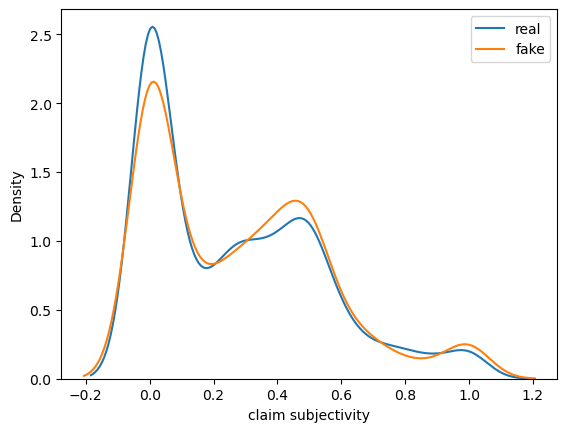

In [156]:
from textblob import TextBlob
X_train['claim subjectivity'] = X_train['claim'].apply(lambda x:TextBlob(x).sentiment.subjectivity)
X_test['claim subjectivity']  = X_test['claim'].apply(lambda x:TextBlob(x).sentiment.subjectivity)
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(x="claim subjectivity", data=X_train[y_train==0])
sns.kdeplot(x="claim subjectivity", data=X_train[y_train==1])
plt.legend(['real','fake'])
plt.show()

### CountVectorizer `claim source`

In [157]:
X_train['claim source']

2635                                              a tweet
2641                                              a tweet
1376    the Republican response to the State of the Un...
891                             an interview on This Week
2482                                       a TV interview
                              ...                        
1111               a speech to the City Club of Cleveland
456                                    a press conference
3267                a speech at the Democratic convention
2760                         a speech to business leaders
3377                                             a speech
Name: claim source, Length: 2770, dtype: object

In [158]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_src = CountVectorizer(stop_words='english', lowercase=True)
vectorizer_src.fit(X_train['claim source'].values)
src_vec_train = vectorizer_src.transform(X_train['claim source']) # fit & transform on train

# only transform on test
src_vec_test = vectorizer_src.transform(X_test['claim source'].values)

src_vec_train.shape

(2770, 888)

### CountVectorizer `Issues`

In [159]:
vectorizer_issues = CountVectorizer()
vectorizer_issues.fit(X_train['issues'].values)
issues_vec_train = vectorizer_issues.transform(X_train['issues']) # fit & transform on train
issues_vec_test = vectorizer_issues.transform(X_test['issues'].values)
issues_vec_train.shape

(2770, 84)

### One-Hot Encoding (OHE) for Categorical Features

- apply on categorical features: ['issue', 'state', 'bio.gender', 'type', 'party']

#### OHE all categorical variables tgt

In [160]:
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix

In [161]:
categorical_variables = ['state', 'bio.gender', 'type', 'party']

X_train_categorical = X_train[categorical_variables]
X_test_categorical = X_test[categorical_variables]

# One-hot encoding
enc_lr = OneHotEncoder(handle_unknown="ignore")

transformer_lr = make_column_transformer((enc_lr, categorical_variables), remainder="passthrough")
X_train_categorical = transformer_lr.fit_transform(X_train_categorical)
X_test_categorical = transformer_lr.transform(X_test_categorical)

age_train = X_train['claimmer age'].values.reshape(-1,1)
age_test = X_test['claimmer age'].values.reshape(-1,1)
subjectivity_train = X_train['claim subjectivity'].values.reshape(-1,1)
subjectivity_test = X_test['claim subjectivity'].values.reshape(-1,1)

X_train_vec = np.hstack([age_train, subjectivity_train, src_vec_train.toarray(), issues_vec_train.toarray(),tfidf_claim_vec_train])
X_test_vec = np.hstack([age_test, subjectivity_test, src_vec_test.toarray(), issues_vec_test.toarray(), tfidf_claim_vec_test])

# then combine with the numerical matrices of the other features 
X_train_combined = np.hstack([X_train_vec, X_train_categorical.toarray()])
X_test_combined = np.hstack([X_test_vec, X_test_categorical.toarray()])

In [162]:
columns = ['claimmer age','claim subjectivity']
columns.extend(list(vectorizer_src.vocabulary_.keys()))
columns.extend(list(vectorizer_issues.vocabulary_.keys()))
columns.extend(list(tfidf_claim_vec.vocabulary_.keys()))
lr_cols = transformer_lr.transformers_[0][1].categories_ #state, bio.gender, type, party
for i in range(4):
    columns.extend(lr_cols[i])


In [163]:
columns.__len__()

7213

In [164]:
X_train_combined.shape, X_test_combined.shape

((2770, 7213), (1188, 7213))

In [165]:
y_train.shape,X_train_combined.shape

((2770,), (2770, 7213))

In [166]:
df_train = pd.DataFrame(data=X_train_combined, columns=columns)
df_train['accuracy'] = y_train.values
df_train.to_csv("train bio.csv")
df_test = pd.DataFrame(data=X_test_combined, columns=columns)
df_test['accuracy'] = y_test.values
df_test.to_csv("test bio.csv")